# **Critic Scores Versus User Scores in Video Games**

Saving Capstone_Image.jpg to Capstone_Image.jpg


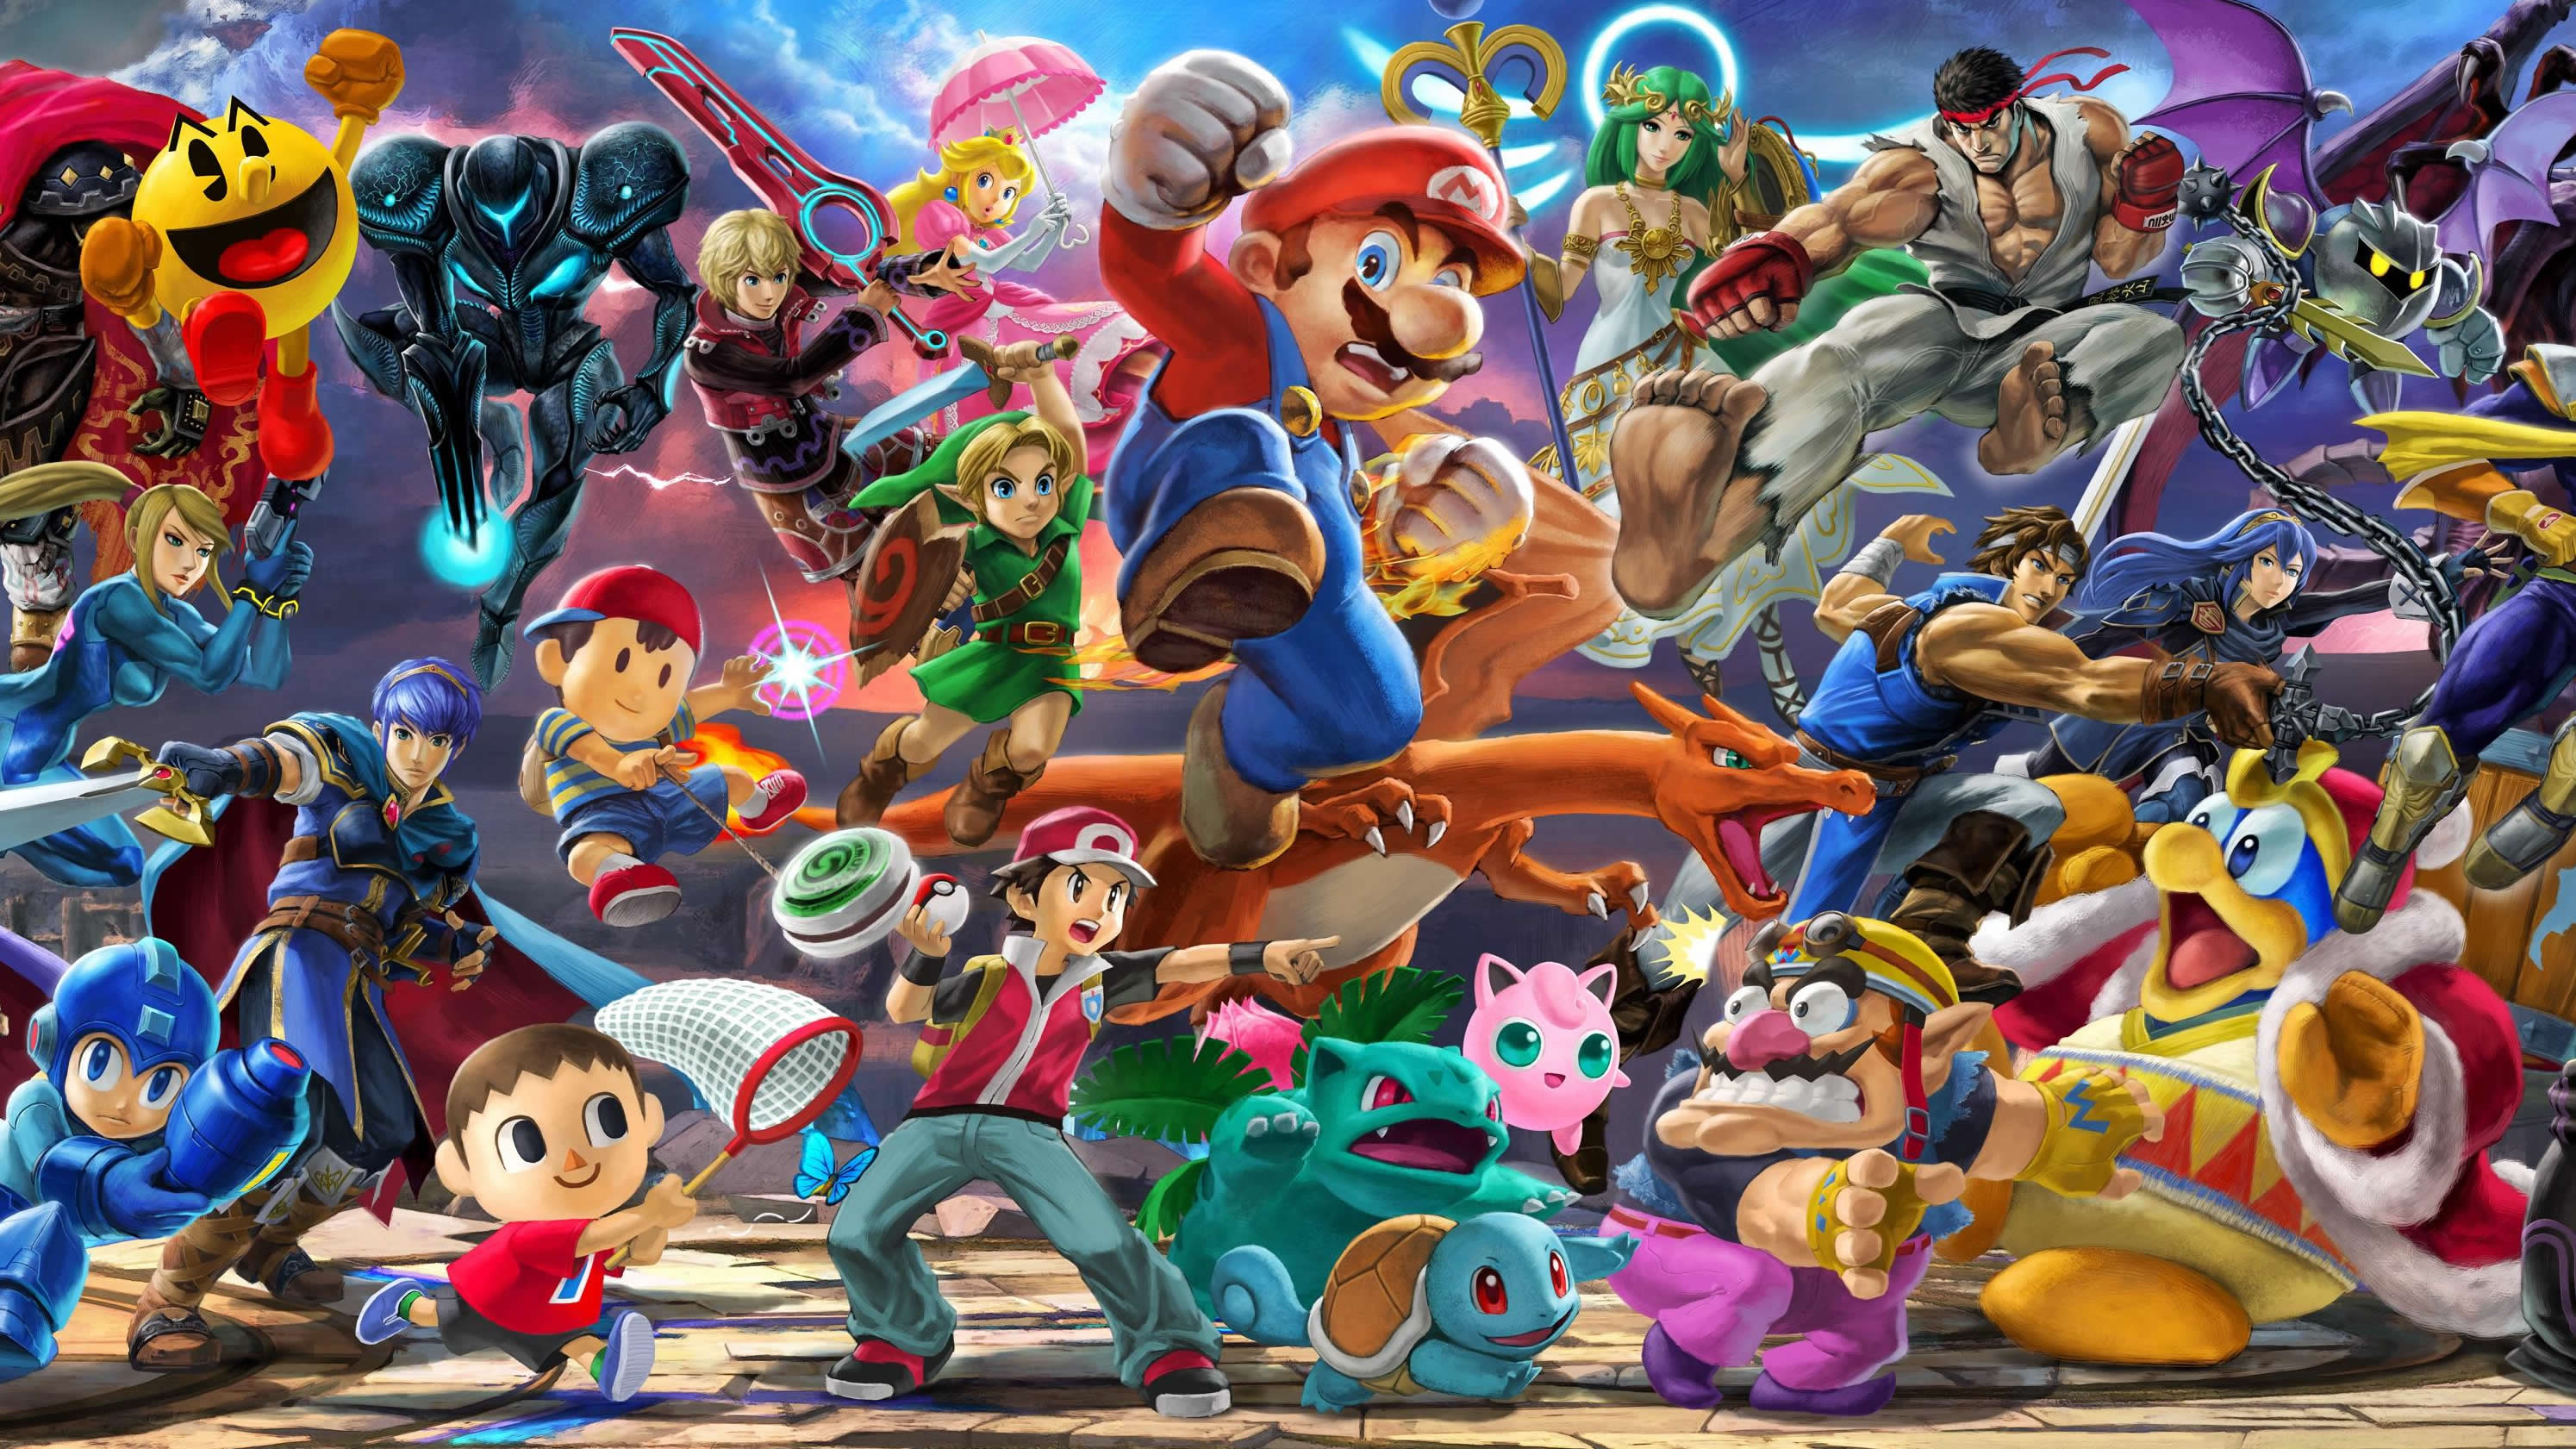

In [0]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='Capstone_Image.jpg') 

# Introduction
This research is centered around Video Game Sales with Ratings, a data set compiling many different attributes of games since 1980. 

The purpose of this research is to test whether professional critics aggregated on Metacritic or the users themselves are a better predictor of sales globally. Professional critics once held powerful sway over the successes and failures of games, but in the era of the internet and YouTube, users’ opinions have become the first stop for many people looking to buy and play video games. 

	

# Data and Methodology

The dataset used for this research comes from Kaggle. Contained within the frame are the titles of the games, their publishers, age-ratings for the games, their sales listed by countries and continents, as well as information regarding scores given to the games by critics and users. 

For the purposes of this research, a number of changes will be made to the original database. Columns that are not relevant to this research will be removed, a new column showing the difference between critic and users scores will be created, and user scores will be converted from an object into a float for statistical and graphical comparison.

# Data Preparation and Exploration

In [0]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go

In [0]:
# Bokeh hvplot, to be used for dynamic and visually stunning graphs.
!pip install -U bokeh hvplot

Requirement already up-to-date: bokeh in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: hvplot in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [0]:
# More imports
from google.colab import files
from IPython.display import Image

uploaded = files.upload()
import hvplot.pandas

import holoviews as hv

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Initial view of the data. Here we can see all of the columns and some of the values populating the dataframe's cells.
game = pd.read_csv('Video_Game_Sales.csv')
game.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# A list of the oldest games produced by each Publisher, to better understand the scope of the data contained in the project.

game.groupby(['Publisher'])['Year_of_Release'].min()

Publisher
10TACLE Studios                 2006.0
1C Company                      2009.0
20th Century Fox Video Games    1981.0
2D Boy                          2008.0
3DO                             1998.0
                                 ...  
id Software                     1992.0
imageepoch Inc.                 2014.0
inXile Entertainment            2015.0
mixi, Inc                       2015.0
responDESIGN                    2004.0
Name: Year_of_Release, Length: 581, dtype: float64

In [0]:
# For research purposes, the earliest year at which data is recorded in this dataframe. This research spans the course of 40 years, from 1980-2020.

print(game.min()['Year_of_Release'])
print(game.max()['Year_of_Release'])

1980.0
2020.0


In [0]:
# Count of the unique values in each column to better understand the data.

game.nunique()

Name               11562
Platform              31
Year_of_Release       39
Genre                 12
Publisher            581
NA_Sales             402
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         629
Critic_Score          82
Critic_Count         106
User_Score            96
User_Count           888
Developer           1696
Rating                 8
dtype: int64

In [0]:
# More relevant information about the database, again including the column names plus the types of data that populate them.
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [0]:
# Upon inspection of the types of data for the columns, we encounter a problem- the User_Score is being stored as an object rather than a float. To proceed with our analysis, we must convert it.
# And so here, User_Score is converted from an object into a float, with errors being returned as NaN.

game["User_Score"] = pd.to_numeric(game.User_Score, errors='coerce')

In [0]:
# Once the User_score is converted from an object into a float, it is multiplied by 10 so that it can be directly compared to the critics' scores, which are on a 1-100 basis.

game2 = game.assign(User_score_adjusted = ((game.User_Score) * 10))
game2.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_score_adjusted
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,80.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,83.0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,80.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# For ease of analysis and direct comparison, we will add a column displaying the difference between the two scores. This is a table with the difference between the Critic_Score
# and the Adjusted_user_score. Negative Scores represent User_Score that exceeds the Critic_Score, and positive values indicate a higher Critic_Score.

game3 = game2.assign(Difference = (game2.Critic_Score - game2.User_score_adjusted))
game3.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_score_adjusted,Difference
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,80.0,-4.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,83.0,-1.0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,80.0,0.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# A new table with Global Sales over 10 million that also have both user and critic scores present, i.e. not null. By limiting the data to "Best Selling Games" we can compare the different scores together
# as two variables, instead of comparing three variables. The new database has only games that have grossed over 10 million sales globally.

Best_selling_games = game3.loc[(game['Global_Sales'] >= 10) & (game['User_Score'].notnull()) & (game['Critic_Score'].notnull())]
Best_selling_games.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_score_adjusted,Difference
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,80.0,-4.0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,83.0,-1.0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,80.0,0.0
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,85.0,4.0
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,66.0,-8.0


In [0]:
# A table of all games with fewer than 10 million sales with both user and critic scores present. This table has thousands of rows.

Other_games = game3[(game['Global_Sales'] <= 10) & (game['User_Score'].notnull()) & (game['Critic_Score'].notnull())]
Other_games.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_score_adjusted,Difference
62,New Super Mario Bros. 2,3DS,2012.0,Platform,Nintendo,3.66,3.14,2.47,0.63,9.90,78.0,70.0,7.2,424.0,Nintendo,E,72.0,6.0
64,Halo: Reach,X360,2010.0,Shooter,Microsoft Game Studios,7.04,1.95,0.08,0.79,9.86,91.0,99.0,7.9,2045.0,Bungie,M,79.0,12.0
65,Final Fantasy VII,PS,1997.0,Role-Playing,Sony Computer Entertainment,3.01,2.47,3.28,0.96,9.72,92.0,20.0,9.2,1282.0,SquareSoft,T,92.0,0.0
66,Halo 4,X360,2012.0,Shooter,Microsoft Game Studios,6.65,2.28,0.04,0.74,9.71,87.0,87.0,7.0,3260.0,343 Industries,M,70.0,17.0
67,Gran Turismo 2,PS,1999.0,Racing,Sony Computer Entertainment,3.88,3.42,1.69,0.50,9.49,93.0,23.0,9.0,135.0,Polyphony Digital,T,90.0,3.0


In [0]:
# A table that has only the relevant data for the best selling games, discarding the columns that are not important.

refined_Best_selling_games = Best_selling_games[['Name', 'Global_Sales','Critic_Score', 'User_score_adjusted', 'Difference']]
refined_Best_selling_games.head()

,Name,Global_Sales,Critic_Score,User_score_adjusted,Difference
0,Wii Sports,82.53,76.0,80.0,-4.0
2,Mario Kart Wii,35.52,82.0,83.0,-1.0
3,Wii Sports Resort,32.77,80.0,80.0,0.0
6,New Super Mario Bros.,29.80,89.0,85.0,4.0
7,Wii Play,28.92,58.0,66.0,-8.0


In [0]:
# Here we have a scatterplot of game titles (Name) versus global sales (in millions of units). In order to add up repeating titles across different platforms, I've used a .sum() method to aggregate
# titles such as 'Grant Theft Auto V,' which has three occurrances across three platforms. 

hv.extension('bokeh')

Best_selling_games.groupby('Name')['Global_Sales'].sum().sort_values().hvplot(kind='scatter', width=1000, height=600, rot=55, padding=.2, title='Global Sales of Best Selling Video Games (Raw)', ylabel='Sales (Million of Units)')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Upon visual inspection, it is clear that the titles 'Grand Theft Auto V' and 'Wii Sports' are significant outliers. For the purposes of the study, it is good practice to remove them from the dataset. We
# could do this with winsorization or another cleaning method, but it's easiest to just remove them manually. 

In [0]:
Best_selling_games2 = refined_Best_selling_games.drop(0, axis=0)
Best_selling_games3 = Best_selling_games2.drop(Best_selling_games2[Best_selling_games2.Name == 'Grand Theft Auto V'].index)

In [0]:
Best_selling_games3.head()

,Name,Global_Sales,Critic_Score,User_score_adjusted,Difference
2,Mario Kart Wii,35.52,82.0,83.0,-1.0
3,Wii Sports Resort,32.77,80.0,80.0,0.0
6,New Super Mario Bros.,29.80,89.0,85.0,4.0
7,Wii Play,28.92,58.0,66.0,-8.0
8,New Super Mario Bros. Wii,28.32,87.0,84.0,3.0


In [0]:
#A new scatterplot that does not include the two significant outliers. 

hv.extension('bokeh')

Best_selling_games3.groupby('Name')['Global_Sales'].sum().sort_values().hvplot(kind='scatter', width=1000, height=600, rot=55, padding=.35, title='Global Sales of Best Selling Video Games (Cleaned)', ylabel='Sales(Millions of Units)', color='purple')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# A bar graph displaying the Critic_Score of all games with over 10 million sales.

hv.extension('bokeh')

Best_selling_games3.groupby('Name')['Critic_Score'].mean().sort_values().hvplot(kind='bar', width=1500, height=600, rot=55, title='Critic Scores of Best Selling Video Games', ylabel='Critic Score', padding=.3)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# A bar graph showing all the Users' scores after they've been adjusted. 

hv.extension('bokeh')

Best_selling_games3.groupby('Name')['User_score_adjusted'].mean().sort_values().hvplot(kind='bar', width=1500, height=600, rot=75, title='User Scores of Best Selling Video Games', ylabel='Adjusted User Score', color='red', padding=.3)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# A scatterplot showing the two scores juxtaposed. Here we can visually see the disparity between the two scores. 
# (The Critic_Score = the Adjusted_user_score for the game "Wii Sports resort")

hv.extension('bokeh')

Best_selling_games3.groupby('Name')['Critic_Score', 'User_score_adjusted'].mean().hvplot(kind='scatter', width=1200, height=800, rot=75, padding=.25, grid=True, title='Critic Score versus User Score Differences', ylabel='Difference', xlabel='Name')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# A bar graph clearly showing the differences between the critic and user scores, grouped by name. Positive scores indicate a higher critic score, negative scores show a higher user score. This visualization
# shows that critics tend to give higher average scores than users do. The disparity between the two scores is also much more apparent when coming from critics- none of the games in this database have a user
# score that is more than 8 than the critic score. By comparison, Call of Duty: Modern Warfare 3 has a critic score that has a difference of 55. This is nearly 7 times more! It is also of great interest to note
# that the top 5 games with the biggest disparities between critics and users are all in the "Call of Duty" series.

hv.extension('bokeh')

Best_selling_games3.groupby('Name')['Difference'].mean().sort_values().hvplot(kind='bar', width=1000, height=750, rot=75, color='green', 
  title='Difference Between Critic and User Scores \n (Positive Scores indicate a higher Critic Score)', ylabel='Difference in Scores', padding=.1)

Output hidden; open in https://colab.research.google.com to view.

# Exploration of Differences in Scores- Testing the Hypothesis

Ho: There is no statistically significant difference between critic and user scores.

Ha: There is a statistically significant different between critic and user scores.

DescribeResult(nobs=36, minmax=(58.0, 98.0), mean=86.27777777777777, variance=91.86349206349207, skewness=-1.1506216996329544, kurtosis=1.26804790029197)
DescribeResult(nobs=36, minmax=(26.0, 90.0), mean=73.0, variance=277.14285714285717, skewness=-1.414504911363241, kurtosis=1.249336082474227)


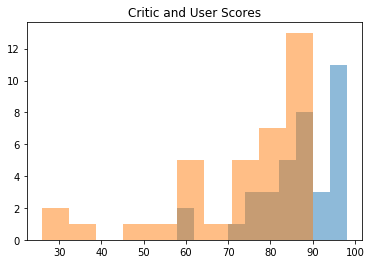

In [0]:
# Both the skewness and kurtosis values fall between the respective tolerances for a t-test to be performed. Upon visual inspection, there is a negative skew, however.

print(stats.describe(Best_selling_games3['Critic_Score']))
print(stats.describe(Best_selling_games3['User_score_adjusted']))
plt.hist(Best_selling_games3['Critic_Score'], alpha=.5)
plt.hist(Best_selling_games3['User_score_adjusted'], alpha=.5)
plt.title('Critic and User Scores')
plt.show()

In [0]:
# The t-test

stats.ttest_ind(Best_selling_games3['Critic_Score'], Best_selling_games3['User_score_adjusted'])

Ttest_indResult(statistic=4.147245330473963, pvalue=9.309096022156848e-05)

# Result of Best Selling Games

Both the statistic and the p-value reject the null. The statistic, at ~4.147, well exceeds the 1.96 limit. The p value, at ~.000093, is also significantly lower than the .05 tolerance value. In terms of our
research, this shows that there is indeed a statistically significant difference between the two scores which we can say with an extremely high degree of certainty.

In [0]:
# A hexbin plot showing clustering of both scores. Upon visual inspection of this data, it appears that the most clustering happens around the (80,80) mark. In contrast to the best selling games, there seem to
# be fewer outliers relative to the sample size. It is also interesting to note that the average score given to games for both critics and users is not 50 as would be expected mathematically, but in the low 70's
# for both. What could the reasons for this be?

hv.extension('bokeh')

Other_games.hvplot.hexbin(x='User_score_adjusted', y='Critic_Score', width=1000, height=600, logz=True, title='Density of Critic Scores versus User Scores for Other Games \n (Darker hexagons means more games)', ylabel='Critic Score', xlabel='User Score')


Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Statistics on the critic score for other games.

Other_games['Critic_Score'].describe()


count    6977.000000
mean       70.154794
std        13.844457
min        13.000000
25%        62.000000
50%        72.000000
75%        80.000000
max        98.000000
Name: Critic_Score, dtype: float64

In [0]:
# Statistics on the user score for other games.

Other_games['User_score_adjusted'].describe()

count    6977.000000
mean       71.812670
std        14.403348
min         5.000000
25%        65.000000
50%        75.000000
75%        82.000000
max        96.000000
Name: User_score_adjusted, dtype: float64

In [0]:
# Here we observe the differences in scores as a more pronounced and symmetrical trend. With thousands of games, we don't see the same skewing that we saw with the differences in the top selling games.
# This could be because of a larger dataset, less risk of paid critics, and for other reasons. While this graph shows near symmetry, there is a slight positive skewing, showing that for other games,
# users tend to assign lower scores. 

hv.extension('bokeh')

Other_games.groupby('Name')['Difference'].mean().sort_values().hvplot(kind='bar', width=1000, height=600, xaxis=None, 
  title='Differences in Scores for Other Games (Positive Scores mean a higher Critic Score)', ylabel='Difference', padding=.05)



Output hidden; open in https://colab.research.google.com to view.

DescribeResult(nobs=6977, minmax=(13.0, 98.0), mean=70.15479432420811, variance=191.66898253008245, skewness=-0.7552076237081944, kurtosis=0.39960870315017516)
DescribeResult(nobs=6977, minmax=(5.0, 96.0), mean=71.81267020209259, variance=207.45644494755373, skewness=-1.2162337038646842, kurtosis=1.6011550473689056)


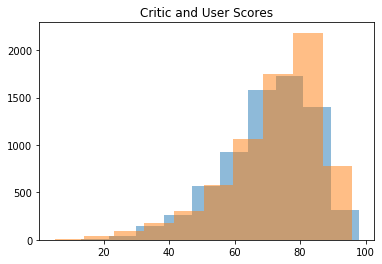

In [0]:
# Skewness and kurtosis values fall well within tolerances for a t-test. The data shows a negative skew, but is relatively normal.

print(stats.describe(Other_games['Critic_Score']))
print(stats.describe(Other_games['User_score_adjusted']))
plt.hist(Other_games['Critic_Score'], alpha=.5)
plt.hist(Other_games['User_score_adjusted'], alpha=.5)
plt.title('Critic and User Scores')
plt.show()

In [0]:
# The results of the t-test reject the null for other games also.

stats.ttest_ind(Other_games['Critic_Score'], Other_games['User_score_adjusted'])

Ttest_indResult(statistic=-6.931570994823132, pvalue=4.344676269238053e-12)

# Result of Other Games

Once again, the t-test shows us that there is a statistically significant difference between the two scores for games that have sold fewer than 10 million copies. Taking into account the p-value, we can assert this with a high degree of confidence.

# Conclusion

The results of the t-tests performed on the two categories of sales within the database show that the null hypothesis has been negated. In other words, there is indeed a statistically significant difference between critic scores and user scores. What are some some possible reasons for this?

1. Given that the biggest disparity between scores were all for the "Call of Duty" series, it seems likely that the developer of these games have paid or otherwise incentivized critics to give them favorable reviews.

2. It may be that the sample of critics reviewing the "Call of Duty" franchise are unusually attracted to those types of games, but this is unlikely.

3. Marketing from companies also plays a role in the reviews. Because critics sometimes receive copies of the games in advance, it may be that they are more susceptible to pre-release "hype" that probably would not affect users as much.

4. Critics are usually paid for their services, so if they want favor with the companies they review, they will rate games higher than users, who have nothing to gain from being more brutally honest with their criticisms.

# Noteworthy Observations and Questions for Future Research

1. The difference in scores from games that sold fewer than 10 million copies globally is significantly more balanced than the top selling games. It would be interesting to know the reasons for this.

2. It would also be interesting and potentially valuable to test the differences between games that sold hardly any copies at all. Would the disparities between the scores be more or less significant?

3. Proceeding to test reviews by country/continent might also lend us additional insight into differences between scores. Are the gaps in the scores more or less pronounced in the United States, for example?

4. It's worth noting that the statistical mean for the many thousands of games that sold fewer than 10 million copies was around 70. Mathematically, we would expect the number to be around 50, so why is the mean 20 points higher? What might the reasons for this be? Does this skew the results at all?

5. How might including the outliers affect the data? We know that Wii Sports and GTA sold significantly more copies than any other game. Would the disparity in reviews be comparable? 

6. Given the trend towards "customer reviews" over paid critics in many industries (Amazon, Google, etc.), might there be some kind of new system or software that could be developed to provide more accurate ratings for games? It may be interesting to test this possibility, but it seems that with the success of the "Call of Duty" series, despite its very low users scores, shows us that companies are still leaning towards marketing and critic reviews to sell copies of games. 